In [1]:
from pyiron_atomistics import Project
import numpy as np
import scipy.special as sc
import matplotlib.pylab as plt
from pyiron_mpie.interactive.art_lammps import ART
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import scipy.ndimage
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from scipy.interpolate import griddata

In [2]:
def get_TDS_constant_1trap(dE,t,T):
    k=0.025/300
    f=np.exp(dE/k/T)*t
    c=1-np.exp(-f)
    return c*10**6,f

def get_TDS_ramp_1trap(dE,T0,T1,beta):
    k=0.025/300
    Ei0=sc.expi(dE/k/T0)
    Ei1=sc.expi(dE/k/T1)
    f0=(T0*np.exp(dE/k/T0)-dE*Ei0/k)/beta
    f1=(T1*np.exp(dE/k/T1)-dE*Ei1/k)/beta
    c=1-np.exp(-(f1-f0))
    return c*10**6,f0,f1

def get_TDS_rate_ramp_1trap(dE,T0,T1,beta):
    k=0.025/300
    Ei1=sc.expi(dE/k/T1)
    dc=np.exp((dE*beta+dE*T1*Ei1+k*T1**2*(-np.exp(dE/k/T1)))/(beta*k*T1))/beta
    return dc*10**6

def get_integral_from_const(CC,N,dT,Tstart,Tfinal):
    NN=np.arange(Tstart,Tfinal,dT)
    for i in range(1,len(CC)+1):
        NN[i-1]=N
    for i in range(1,len(CC)+1):
        if i==1:
            NN[i-1]=N-CC[i-1]*N
        NN[i-1]=NN[i-2]-CC[i-1]*NN[i-2]
    for i in range(1,len(CC)+1):
        NN[i-1]=N-NN[i-1]
    dN=np.diff(NN)/dT
    dN1 = np.append(0,dN)
    return NN/N,(10**6)*dN1/N

def get_ramp_from_const(dT,dTdt,Tstart,Tfinal,dE):
    dt= dT/dTdt
    TT=np.arange(Tstart,Tfinal,dT)
    CC=np.arange(Tstart,Tfinal,dT)
    for i in range(1,len(CC)+1):
        Tcon=TT[i-1]
        CCC,ff=get_TDS_constant_1trap(dE,dt,Tcon)
        CC[i-1]=CCC#*10**(-6)
    return CC*10**(-6)
        

In [3]:
dT=100
dTdt=0.1
Tstart=300
Tfinal=1101
dE=-0.4
dE2=-0.5

In [4]:
Trange=np.arange(Tstart,Tfinal,1)
Crange=np.arange(Tstart,Tfinal,1)
dCrange=np.arange(Tstart,Tfinal,1)
ff0=np.arange(Tstart,Tfinal,1)
ff1=np.arange(Tstart,Tfinal,1)
for i in range(1,len(Trange)+1):
    TT=Trange[i-1]
    Crange[i-1],ff0[i-1],ff1[i-1]=get_TDS_ramp_1trap(dE,300,TT,dTdt)
    dCrange[i-1]=get_TDS_rate_ramp_1trap(dE,300,TT,dTdt)

In [5]:
Trange2=np.arange(Tstart,Tfinal,1)
Crange2=np.arange(Tstart,Tfinal,1)
dCrange2=np.arange(Tstart,Tfinal,1)
ff02=np.arange(Tstart,Tfinal,1)
ff12=np.arange(Tstart,Tfinal,1)
for i in range(1,len(Trange)+1):
    TT2=Trange[i-1]
    Crange2[i-1],ff02[i-1],ff12[i-1]=get_TDS_ramp_1trap(dE2,300,TT2,dTdt)
    dCrange2[i-1]=get_TDS_rate_ramp_1trap(dE2,300,TT2,dTdt)

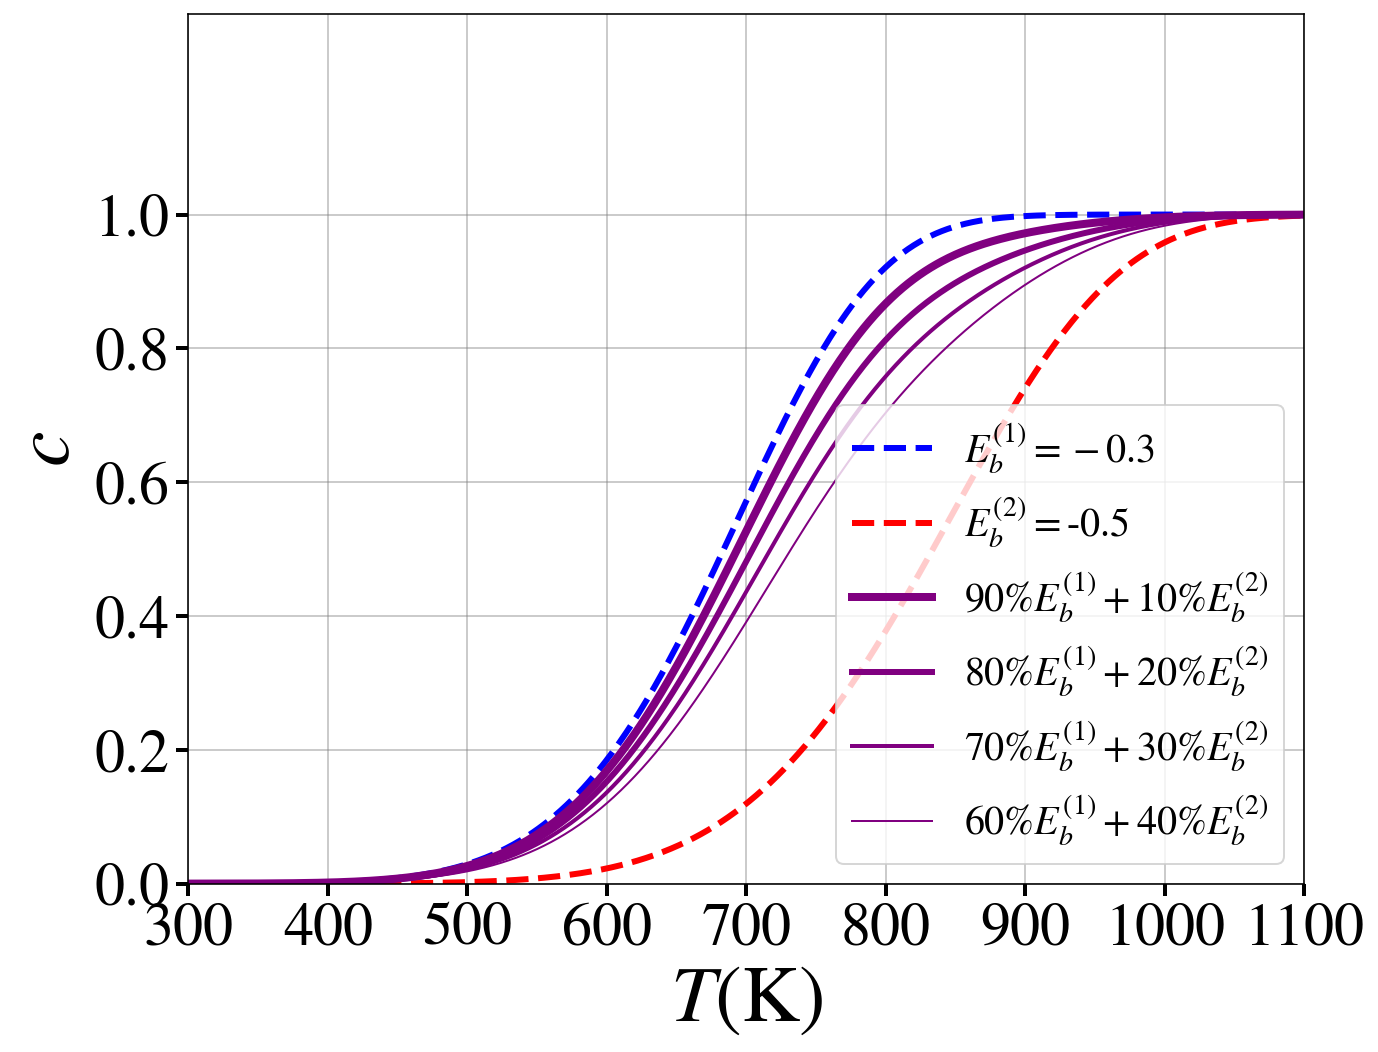

In [6]:
fig_qh=plt.figure(figsize=(10,8))
[l1,l2,l3,l4,l5,l6]=plt.plot(Trange,Crange/10**6,Trange2,Crange2/10**6,Trange2,(0.9*Crange/10**6+0.1*Crange2/10**6),
                    Trange2,(0.8*Crange/10**6+0.2*Crange2/10**6),Trange2,(0.7*Crange/10**6+0.3*Crange2/10**6),Trange2,(0.6*Crange/10**6+0.4*Crange2/10**6))
plt.setp(l1,color='blue',linestyle='dashed', linewidth=3, label='$E_b^{(1)}=-0.3$')
plt.setp(l2,color='red',linestyle='dashed', linewidth=3, label='$E_b^{(2)}=$'+str(dE2))
plt.setp(l3,color='purple',linestyle='solid', linewidth=4, label='$90\%E_b^{(1)}+10\% E_b^{(2)}$')
plt.setp(l4,color='purple',linestyle='solid', linewidth=3, label='$80\%E_b^{(1)}+20\% E_b^{(2)}$')
plt.setp(l5,color='purple',linestyle='solid', linewidth=2, label='$70\%E_b^{(1)}+30\% E_b^{(2)}$')
plt.setp(l6,color='purple',linestyle='solid', linewidth=1, label='$60\%E_b^{(1)}+40\% E_b^{(2)}$')

plt.xlabel('$T$(K)',fontsize=40)
plt.ylabel('$c$',fontsize=40)
plt.xticks([300,400,500,600,700,800,900,1000,1100],fontsize=30, rotation=0)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],fontsize=30, rotation=0)
plt.tick_params(direction='out', length=6, width=2, colors='black',
               grid_color='grey', grid_alpha=0.5)
plt.xlim(300,1100)
plt.ylim(0,1.3)
plt.grid()
plt.legend(fontsize=28,ncol=2)
#plt.title('1st ANNNI approximation',fontsize=40)
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.99),fontsize=20,ncol=1)
plt.savefig('C_T.png')
plt.savefig('C_T.svg')

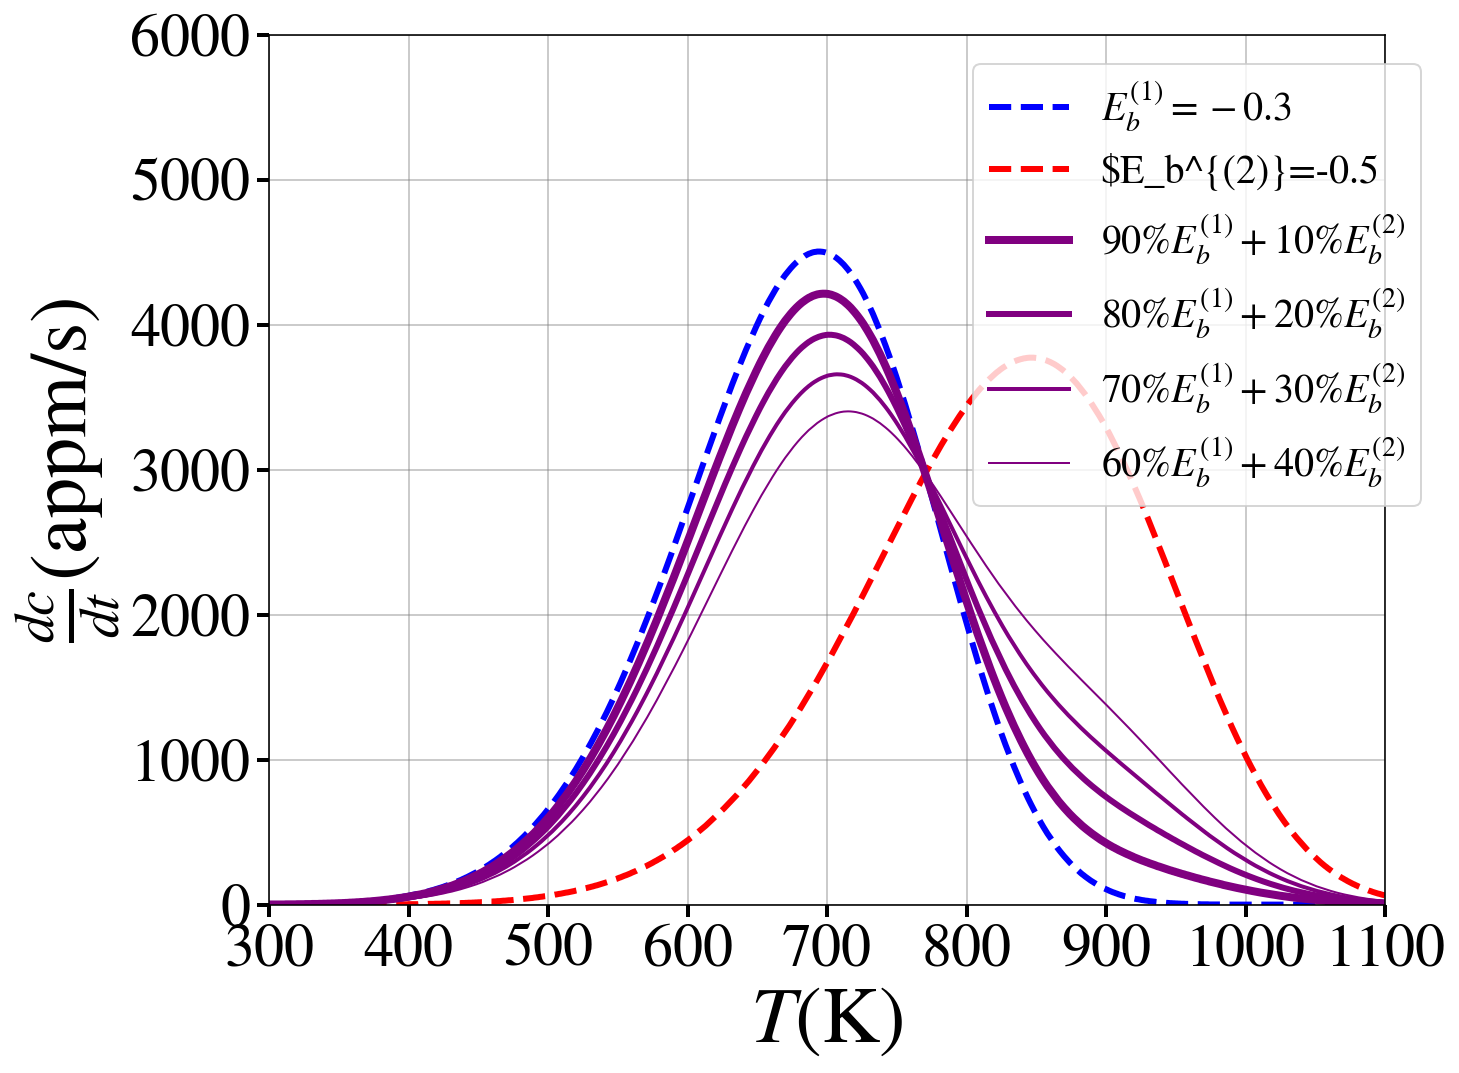

In [7]:
fig_qh=plt.figure(figsize=(10,8))
[l1,l2,l3,l4,l5,l6]=plt.plot(Trange,dCrange,Trange,dCrange2,Trange,0.9*dCrange+0.1*dCrange2,Trange,0.8*dCrange+0.2*dCrange2,
         Trange,0.7*dCrange+0.3*dCrange2,Trange,0.6*dCrange+0.4*dCrange2)

plt.setp(l1,color='blue',linestyle='dashed', linewidth=3, label='$E_b^{(1)}=-0.3$')
plt.setp(l2,color='red',linestyle='dashed', linewidth=3, label='$E_b^{(2)}='+str(dE2))
plt.setp(l3,color='purple',linestyle='solid', linewidth=4, label='$90\%E_b^{(1)}+10\% E_b^{(2)}$')
plt.setp(l4,color='purple',linestyle='solid', linewidth=3, label='$80\%E_b^{(1)}+20\% E_b^{(2)}$')
plt.setp(l5,color='purple',linestyle='solid', linewidth=2, label='$70\%E_b^{(1)}+30\% E_b^{(2)}$')
plt.setp(l6,color='purple',linestyle='solid', linewidth=1, label='$60\%E_b^{(1)}+40\% E_b^{(2)}$')

plt.xlabel('$T$(K)',fontsize=40)
plt.ylabel('$\\frac{dc}{dt}$(appm/s)',fontsize=40)
plt.xticks([300,400,500,600,700,800,900,1000,1100],fontsize=30, rotation=0)
plt.yticks([0,1000,2000,3000,4000,5000,6000],fontsize=30, rotation=0)
plt.tick_params(direction='out', length=6, width=2, colors='black',
               grid_color='grey', grid_alpha=0.5)
plt.xlim(300,1100)
plt.ylim(0,6000)
plt.grid()
plt.legend(fontsize=28,ncol=1)
#plt.title('1st ANNNI approximation',fontsize=40)
plt.legend(loc='best', bbox_to_anchor=(0.55, 0., 0.5, 0.99),fontsize=20,ncol=1)
plt.savefig('dC_T.png')
plt.savefig('dC_T.svg')


In [10]:
N=10**9
myNN,mydN=get_integral_from_const(CC,N,dT,Tstart,Tfinal)
print(myNN)
print(CC)


N=10**9
myNN2,mydN2=get_integral_from_const(CC,N,dT/2,Tstart,Tfinal)
print(myNN2)
print(TT)

NameError: name 'CC' is not defined

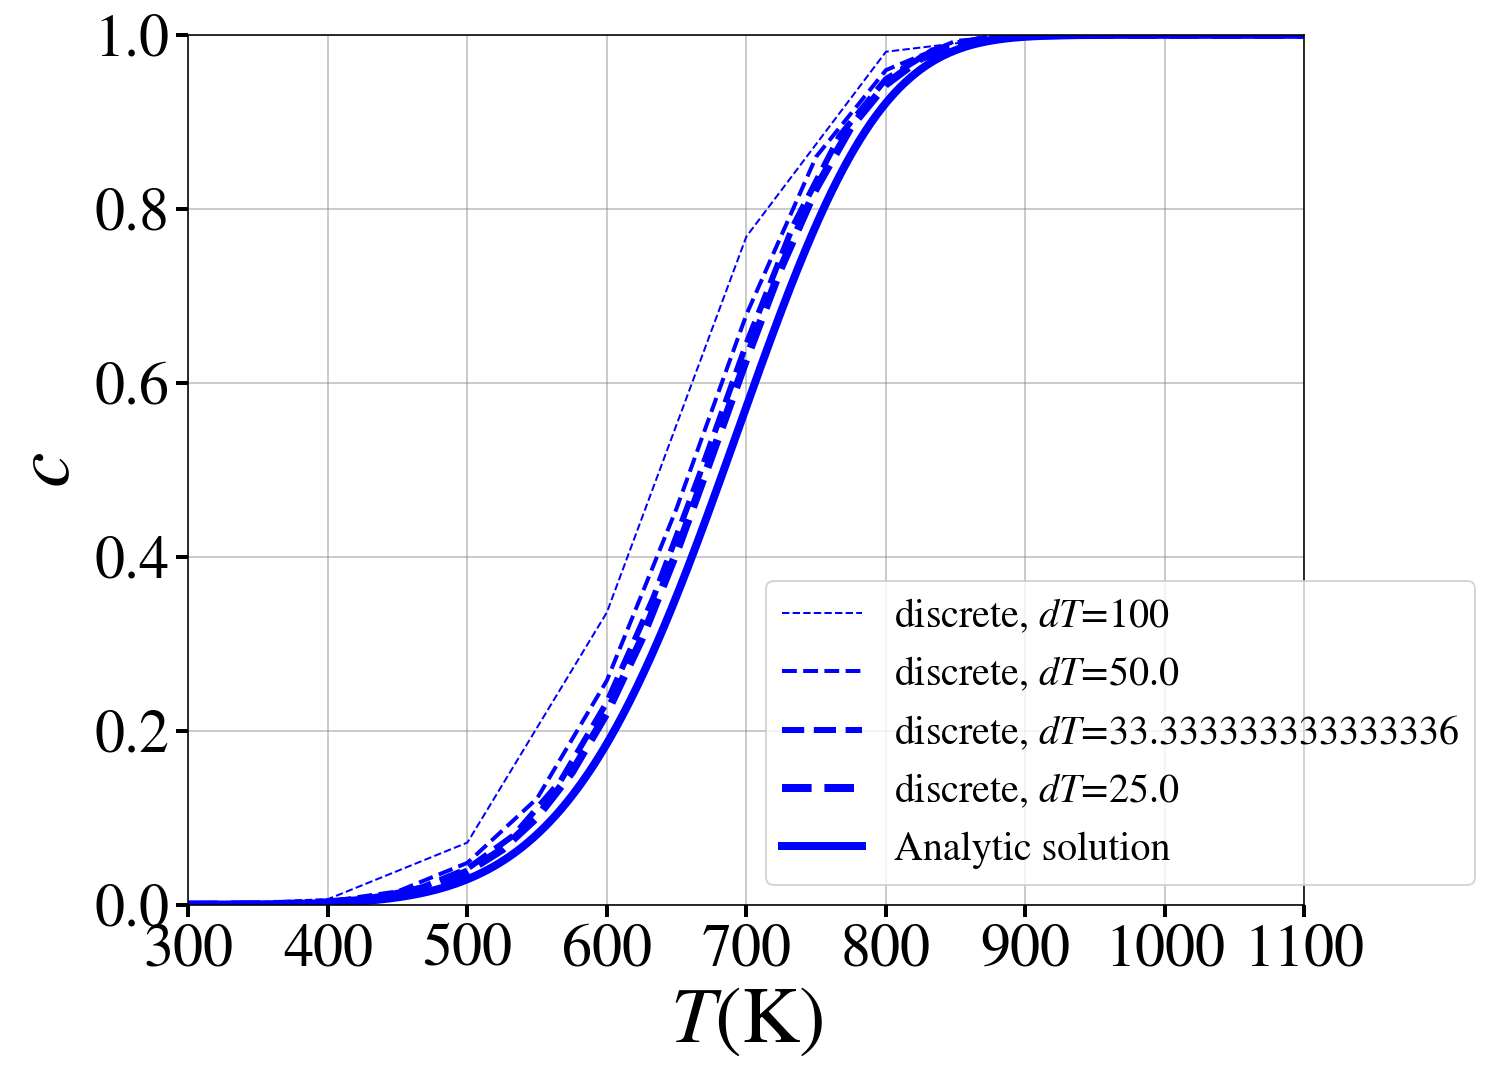

In [11]:
fig_qh=plt.figure(figsize=(10,8))
TT=np.arange(Tstart,Tfinal,dT)
TT2=np.arange(Tstart,Tfinal,dT/2)
TT3=np.arange(Tstart,Tfinal,dT/3)
TT4=np.arange(Tstart,Tfinal,dT/4)
CC=get_ramp_from_const(dT,dTdt,Tstart,Tfinal,dE)
CC2=get_ramp_from_const(dT/2,dTdt,Tstart,Tfinal,dE)
CC3=get_ramp_from_const(dT/3,dTdt,Tstart,Tfinal,dE)
CC4=get_ramp_from_const(dT/4,dTdt,Tstart,Tfinal,dE)


myNN,mydN=get_integral_from_const(CC,N,dT,Tstart,Tfinal)
myNN2,mydN2=get_integral_from_const(CC2,N,dT/2,Tstart,Tfinal)
myNN3,mydN3=get_integral_from_const(CC3,N,dT/3,Tstart,Tfinal)
myNN4,mydN4=get_integral_from_const(CC4,N,dT/4,Tstart,Tfinal)

[l1,l2,l3,l4,l0]=plt.plot(TT,myNN,TT2,myNN2,TT3,myNN3,TT4,myNN4,Trange,Crange/10**6)
plt.setp(l0,color='blue',linestyle='solid', linewidth=4, label='Analytic solution')
plt.setp(l1,color='blue',linestyle='dashed', linewidth=1, label='discrete, $dT$='+str(dT))
plt.setp(l2,color='blue',linestyle='dashed', linewidth=2, label='discrete, $dT$='+str(dT/2))
plt.setp(l3,color='blue',linestyle='dashed', linewidth=3, label='discrete, $dT$='+str(dT/3))
plt.setp(l4,color='blue',linestyle='dashed', linewidth=4, label='discrete, $dT$='+str(dT/4))
plt.xlabel('$T$(K)',fontsize=40)
plt.ylabel('$c$',fontsize=40)
plt.xticks([300,400,500,600,700,800,900,1000,1100],fontsize=30, rotation=0)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],fontsize=30, rotation=0)
plt.tick_params(direction='out', length=6, width=2, colors='black',
               grid_color='grey', grid_alpha=0.5)
plt.xlim(300,1100)
plt.ylim(0,1.0)
plt.grid()
plt.legend(fontsize=28,ncol=2)
#plt.title('1st ANNNI approximation',fontsize=40)
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.99),fontsize=20,ncol=1)
plt.savefig('dis_C_T.png')
plt.savefig('dis_C_T.svg')

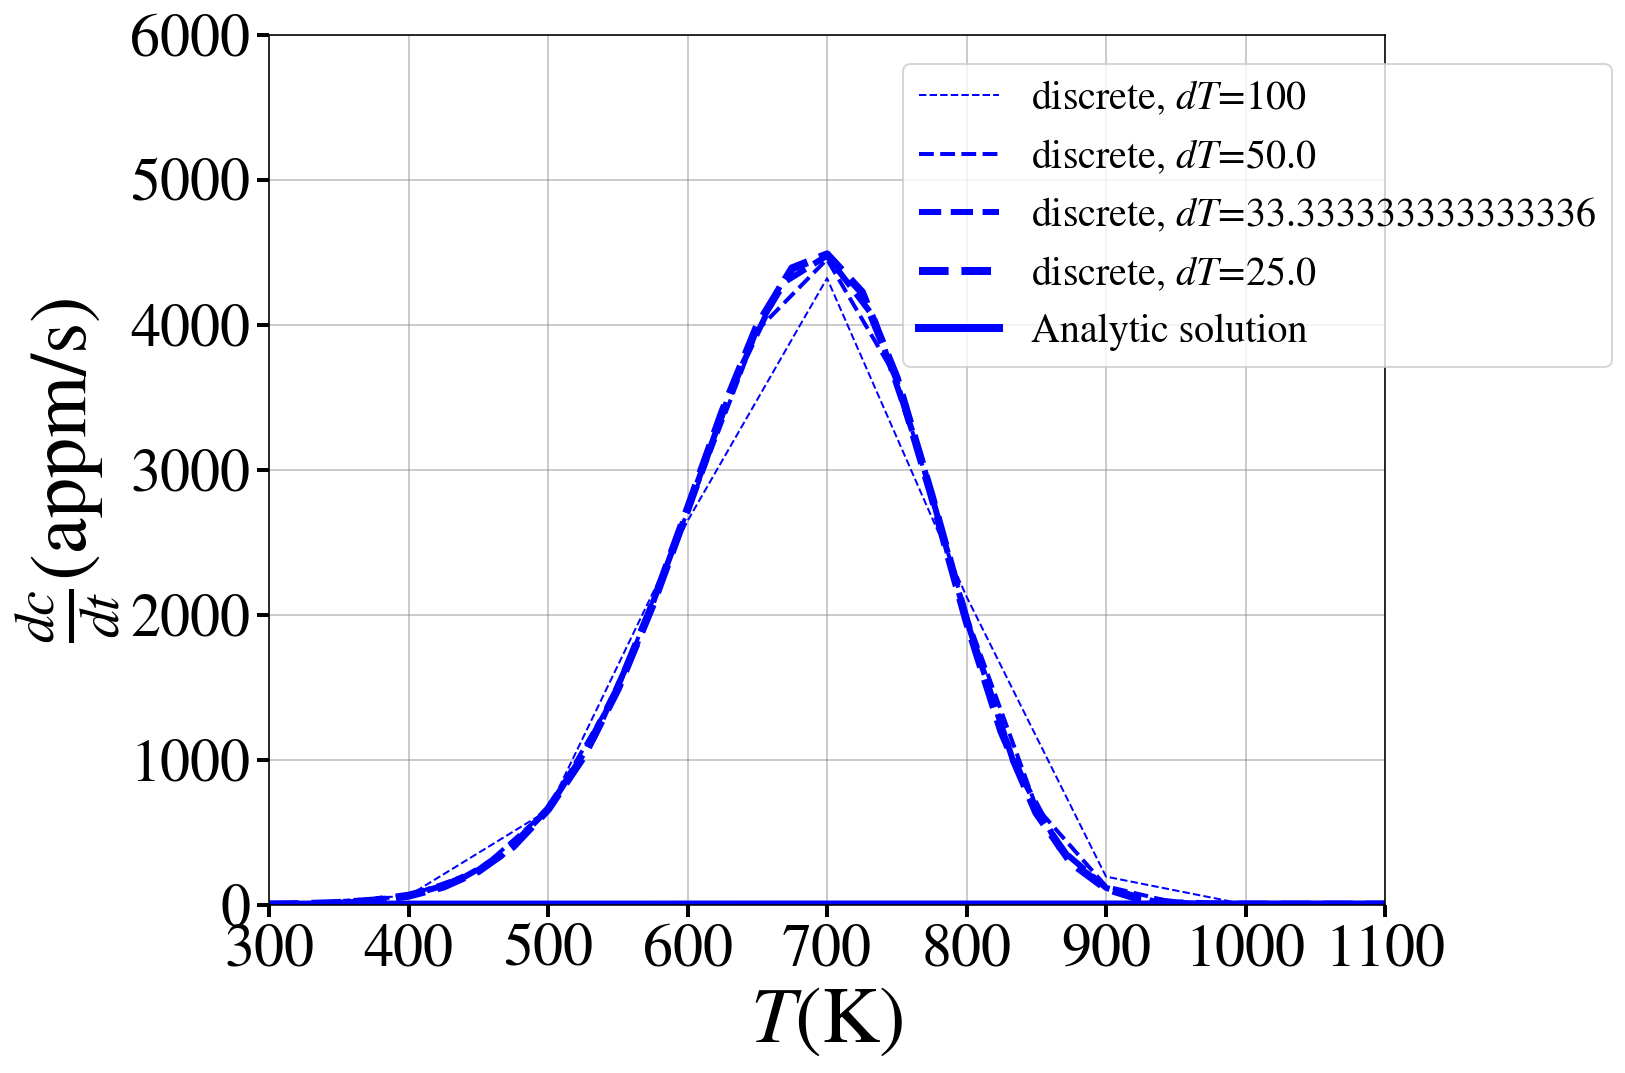

In [12]:
fig_qh=plt.figure(figsize=(10,8))
[l1,l2,l3,l4,l0]=plt.plot(TT,mydN,TT2,mydN2,TT3,mydN3,TT4,mydN4,Trange,Crange/10**6)
plt.setp(l0,color='blue',linestyle='solid', linewidth=4, label='Analytic solution')
plt.setp(l1,color='blue',linestyle='dashed', linewidth=1, label='discrete, $dT$='+str(dT))
plt.setp(l2,color='blue',linestyle='dashed', linewidth=2, label='discrete, $dT$='+str(dT/2))
plt.setp(l3,color='blue',linestyle='dashed', linewidth=3, label='discrete, $dT$='+str(dT/3))
plt.setp(l4,color='blue',linestyle='dashed', linewidth=4, label='discrete, $dT$='+str(dT/4))
plt.xlabel('$T$(K)',fontsize=40)
plt.ylabel('$\\frac{dc}{dt}$(appm/s)',fontsize=40)
plt.xticks([300,400,500,600,700,800,900,1000,1100],fontsize=30, rotation=0)
plt.yticks([0,1000,2000,3000,4000,5000,6000],fontsize=30, rotation=0)
plt.tick_params(direction='out', length=6, width=2, colors='black',
               grid_color='grey', grid_alpha=0.5)
plt.xlim(300,1100)
plt.ylim(0,6000)
plt.grid()
plt.legend(fontsize=28,ncol=1)
#plt.title('1st ANNNI approximation',fontsize=40)
plt.legend(loc='best', bbox_to_anchor=(0.55, 0., 0.5, 0.99),fontsize=20,ncol=1)
plt.savefig('dis_dC_T.png')
plt.savefig('dis_dC_T.svg')

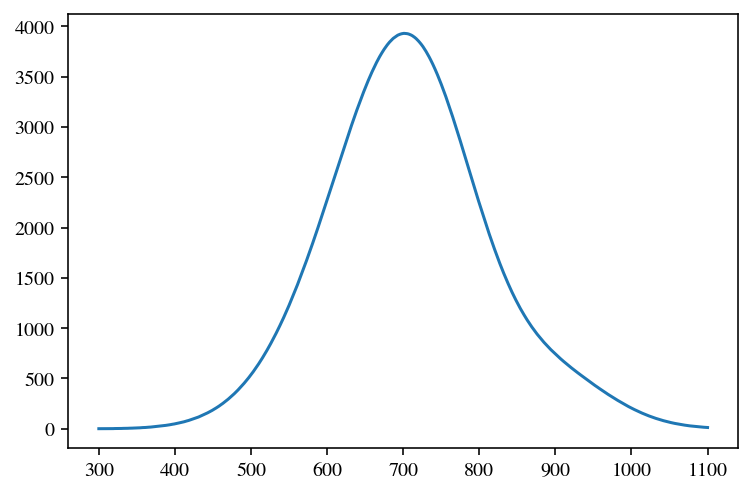

In [13]:
myDistrib=0.8*dCrange+0.2*dCrange2
# from scipy.optimize import curve_fit
# def func(x, a_1, b_1, c_1,a_2, b_2, c_2,a_3, b_3, c_3,a_4, b_4, c_4,a_5, b_5, c_5,a_6, b_6, c_6):
#     f1=a_1 * np.exp(-(x-b_1-300)**2/2/c_1**2)
#     f2=a_2 * np.exp(-(x-b_2-300)**2/2/c_2**2)
#     f3=a_3 * np.exp(-(x-b_3-300)**2/2/c_3**2)
#     f4=a_4 * np.exp(-(x-b_4-300)**2/2/c_4**2)
#     f5=a_5 * np.exp(-(x-b_5-300)**2/2/c_5**2)
#     f6=a_6 * np.exp(-(x-b_6-300)**2/2/c_6**2)
#     f=f1+f2+f3+f4+f5+f6
#     return f

# def func_1(x, a_1, b_1, c_1):
#     f=a_1 * np.exp(-(x-b_1-300)**2/2/c_1**2)
#     return f
plt.plot(Trange,myDistrib)

In [14]:
# p0 = 3000,850,500,3000,750,200,1000,750,300,1000,750,300,1000,750,300,1000,750,300
# popt, pcov = curve_fit(func, Trange, myDistrib,p0,bounds=(0, [10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,
#                                                               10000,10000,10000,10000,10000,10000,10000,10000]))
# popt

In [15]:
# p0 = 3000,550,300
# popt1, pcov = curve_fit(func_1, Trange, myDistrib,p0,bounds=(0, [10000,10000,10000]))
# Trange2=np.arange(Tstart,Tfinal+300,1)
# plt.plot(Trange,myDistrib,Trange2-300,func_1(Trange2-300,popt1[0],popt1[1],popt1[2]))
# #MyDistrib2=MyDistrib-

In [16]:
# Trange2=np.arange(Tstart,Tfinal+300,1)
# plt.plot(Trange,myDistrib,Trange2-300,func_1(Trange2-300,popt[0],popt[1],popt[2]),
#          Trange2-300,func_1(Trange2-300,popt[3],popt[4],popt[5]),
#          Trange2-300,func_1(Trange2-300,popt[6],popt[7],popt[8]),
#          Trange2-300,func_1(Trange2-300,popt[9],popt[10],popt[11]),
#          Trange2-300,func_1(Trange2-300,popt[12],popt[13],popt[14]),
#          Trange2-300,func_1(Trange2-300,popt[15],popt[16],popt[17]),Trange2-300,func(Trange2-300,
#                                                                                      popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7],popt[8]
#                                                                                      ,popt[9],popt[10],popt[11],popt[12],popt[13],popt[14],popt[15],popt[16]
#                                                                                      ,popt[17]))

[[Model]]
    (((Model(skewed_gaussian, prefix='sg1_') + Model(skewed_gaussian, prefix='sg2_')) + Model(skewed_gaussian, prefix='sg3_')) + Model(skewed_gaussian, prefix='sg4_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20932
    # data points      = 801
    # variables        = 16
    chi-square         = 46338.0565
    reduced chi-square = 59.0293713
    Akaike info crit   = 3282.34419
    Bayesian info crit = 3357.31796
[[Variables]]
    sg1_amplitude:  840347.069 +/- 12580.2734 (1.50%) (init = 6000)
    sg1_center:     759.192637 +/- 0.51299567 (0.07%) (init = 700)
    sg1_sigma:      116.815630 +/- 0.79413918 (0.68%) (init = 300)
    sg1_gamma:     -1.20386629 +/- 0.01529276 (1.27%) (init = 10)
    sg2_amplitude:  61646.3804 +/- 2418857.87 (3923.76%) (init = 400)
    sg2_center:     468.103826 +/- 24668.8707 (5269.96%) (init = 700)
    sg2_sigma:      2240.99723 +/- 87935.2316 (3923.93%) (init = 300)
    sg2_gamma:      15241.9192 +/- 3.6157e+09 

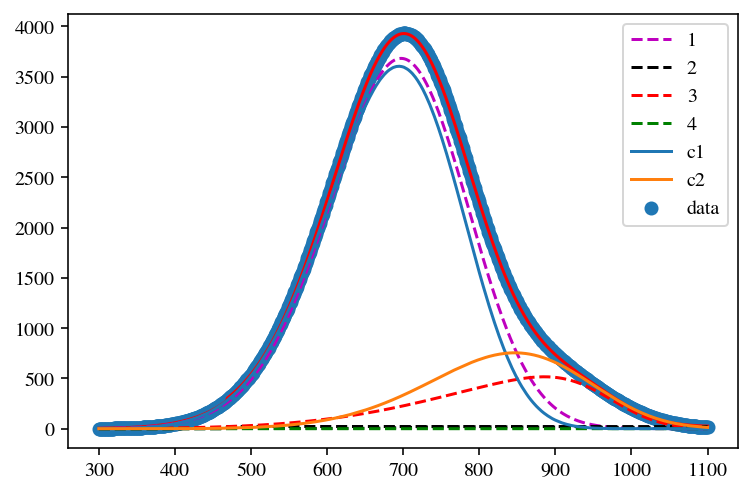

In [17]:
import numpy as np
from lmfit.models import GaussianModel, ExponentialModel,SkewedGaussianModel
import sys
import matplotlib.pyplot as plt

#dat = np.loadtxt('NIST_Gauss2.dat')
x = Trange#data[:,0]
y = myDistrib#data[:,1]


sgauss1  = SkewedGaussianModel(prefix='sg1_')
pars = sgauss1.guess(y, x=x)
pars.update( sgauss1.make_params())

pars['sg1_center'].set(700, min=300, max=1100)
pars['sg1_sigma'].set(300, min=10)
pars['sg1_amplitude'].set(6000, min=10)
pars['sg1_gamma'].set(10)
sgauss2  = SkewedGaussianModel(prefix='sg2_')
pars.update(sgauss2.make_params())

pars['sg2_center'].set(700, min=300, max=1100)
pars['sg2_sigma'].set(300, min=10)
pars['sg2_amplitude'].set(400, min=10)
pars['sg2_gamma'].set(10)

sgauss3  = SkewedGaussianModel(prefix='sg3_')
pars.update( sgauss3.make_params())

pars['sg3_center'].set(950, min=300, max=1100)
pars['sg3_sigma'].set(300, min=10)
pars['sg3_amplitude'].set(1000, min=10)
pars['sg3_gamma'].set(-1)

sgauss4  = SkewedGaussianModel(prefix='sg4_')

pars.update(sgauss4.make_params())

pars['sg4_center'].set(950, min=300, max=1100)
pars['sg4_sigma'].set(300, min=10)
pars['sg4_amplitude'].set(1000, min=10)
pars['sg4_gamma'].set(-1)



smod = sgauss1 + sgauss2 + sgauss3 + sgauss4

init = smod.eval(pars, x=x)
plt.scatter(x, y,label='data' )
plt.plot(x, init, 'k--')

sout = smod.fit(y, pars, x=x)
scomps = sout.eval_components(x=x)
print(sout.fit_report(min_correl=0.5))

plt.plot(x, sout.best_fit, 'r')

plt.plot(x, scomps['sg1_'], 'm--', label='1')
plt.plot(x, scomps['sg2_'], 'k--', label='2')
plt.plot(x, scomps['sg3_'], 'r--', label='3')
plt.plot(x, scomps['sg4_'], 'g--', label='4')
plt.plot(Trange,0.8*dCrange, label='c1')
plt.plot(Trange,0.2*dCrange2, label='c2') 
plt.legend()
plt.show()

In [19]:
plt.plot(x, comps['sg1_'], 'm--', label='1')
plt.plot(x, comps['sg2_'], 'k--', label='2')
plt.plot(x, comps['sg3_'], 'r--', label='3')
plt.plot(x, comps['sg4_'], 'g--', label='4')

NameError: name 'comps' is not defined

In [ ]:
import numpy as np
from lmfit.models import GaussianModel, ExponentialModel
import sys
import matplotlib.pyplot as plt

#dat = np.loadtxt('NIST_Gauss2.dat')
x = Trange#data[:,0]
y = myDistrib#data[:,1]


gauss1  = GaussianModel(prefix='g1_')
pars = gauss1.guess(y, x=x)
pars.update( gauss1.make_params())

pars['g1_center'].set(700, min=300, max=1100)
pars['g1_sigma'].set(300, min=10)
pars['g1_amplitude'].set(8000, min=10)
#pars['g1_gamma'].set(1)

gauss2  = GaussianModel(prefix='g2_')

pars.update(gauss2.make_params())

pars['g2_center'].set(700, min=300, max=1100)
pars['g2_sigma'].set(300, min=10)
pars['g2_amplitude'].set(400, min=10)
#pars['g2_gamma'].set(1)

gauss3  = GaussianModel(prefix='g3_')

pars.update(gauss3.make_params())

pars['g3_center'].set(950, min=300, max=1100)
pars['g3_sigma'].set(300, min=10)
pars['g3_amplitude'].set(1000, min=10)

gauss4  = GaussianModel(prefix='g4_')

pars.update(gauss4.make_params())

pars['g4_center'].set(950, min=300, max=1100)
pars['g4_sigma'].set(300, min=10)
pars['g4_amplitude'].set(1000, min=10)



mod = gauss1 + gauss2 + gauss3 + gauss4

init = mod.eval(pars, x=x)
plt.scatter(x, y,label='data')
#plt.plot(x, init, 'k--')

out = mod.fit(y, pars, x=x)
comps = out.eval_components(x=x)
print(out.fit_report(min_correl=0.5))
plt.plot(x, out.best_fit, 'r-',label='total')
plt.plot(x, comps['g1_'], 'm--', label='1')
plt.plot(x, comps['g2_'], 'k--', label='2')
plt.plot(x, comps['g3_'], 'r--', label='3')
plt.plot(x, comps['g4_'], 'g--', label='4')
plt.plot(Trange,0.8*dCrange, label='c1')
plt.plot(Trange,0.2*dCrange2, label='c2') 
plt.legend()
plt.show()

In [ ]:
plt.plot(x, comps['g1_'], 'm--', label='1')
plt.plot(x, comps['g2_'], 'k--', label='2')
plt.plot(x, comps['g3_'], 'r--', label='3')
plt.plot(x, comps['g4_'], 'g--', label='4')
plt.plot(x, scomps['sg1_'], 'm', label='1s')
plt.plot(x, scomps['sg2_'], 'k', label='2s')
plt.plot(x, scomps['sg3_'], 'r', label='3s')
plt.plot(x, scomps['sg4_'], 'g', label='4s')
plt.plot(Trange,0.8*dCrange,'black', label='c1')
plt.plot(Trange,0.2*dCrange2,'black' ,label='c2') 
plt.legend()

In [ ]:
def function_1(T1,dE,dE2,dE3,w1,w2,w3):
    T0=300
    beta=0.1
    k=0.025/300
    Ei1=sc.expi(dE/k/T1)
    v=(dE*beta+dE*T1*Ei1+k*T1**2*(-np.exp(dE/k/T1)))/(beta*k*T1)
    dc=np.exp(v)/beta
    
    EEi1=sc.expi(dE2/k/T1)
    vv=(dE2*beta+dE2*T1*EEi1+k*T1**2*(-np.exp(dE2/k/T1)))/(beta*k*T1)
    ddc=np.exp(vv)/beta
    EEEi1=sc.expi(dE3/k/T1)
    vvv=(dE3*beta+dE3*T1*EEEi1+k*T1**2*(-np.exp(dE3/k/T1)))/(beta*k*T1)
    dddc=np.exp(vvv)/beta
    dctot=w1*dc+w2*ddc+w3*dddc
    return dctot*10**6

In [ ]:
from scipy.optimize import curve_fit
#Fit for the parameters a, b, c of the function func:
popt, pcov = curve_fit(function_1, x, y,bounds=([-2,-2,-2,0,0,0],[0,0,0,1,1,0.1]))
plt.plot(x,function_1(x, *popt), 'r-')
popt1=np.array([popt[0],popt[1],popt[2],popt[3],0.0,0.0])
plt.plot(x,function_1(x, *popt1), 'b--')
popt2=np.array([popt[0],popt[1],popt[2],0.0,popt[4],popt[5]])
plt.plot(x,function_1(x, *popt2), 'g--')
plt.plot(Trange,0.8*dCrange,'black', label='c1')
plt.plot(Trange,0.2*dCrange2,'black' ,label='c2') 
#popt3=np.array([popt[0],popt[1],popt[2],0.0,0.0,popt[5]])
#plt.plot(x,function_1(x, *popt2), 'black')

#plt.plot(x, function_1(x, *popt), 'g--',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()



In [ ]:
popt1

In [ ]:
popt

In [ ]:
#(x**M1)*((1-x)**N1)*(-log(1-x))**P1
mod1 = ExpressionModel('off + amp * exp(-x/x0) * sin(x*phase)', ndependent_vars=x)
params = mod1.make_params(off=1,amp=2.0, phase=3.0)

In [ ]:
x=np.linspace(1,100)
init = mod.eval(params, x=x)


[[Model]]
    (((Model(skewed_gaussian, prefix='sg1_') + Model(skewed_gaussian, prefix='sg2_')) + Model(skewed_gaussian, prefix='sg3_')) + Model(skewed_gaussian, prefix='sg4_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1261
    # data points      = 6369
    # variables        = 16
    chi-square         = 9.0826e-06
    reduced chi-square = 1.4297e-09
    Akaike info crit   = -129693.993
    Bayesian info crit = -129585.846
[[Variables]]
    sg1_amplitude:  0.24841540 +/- 0.01438848 (5.79%) (init = 0.001)
    sg1_center:     141.260816 +/- 0.08345933 (0.06%) (init = 200)
    sg1_sigma:      115.568163 +/- 5.60742727 (4.85%) (init = 10)
    sg1_gamma:      7.25217844 +/- 0.33187580 (4.58%) (init = -1)
    sg2_amplitude:  0.22965792 +/- 0.00988803 (4.31%) (init = 0.001)
    sg2_center:     288.115438 +/- 47950.6739 (16642.87%) (init = 250)
    sg2_sigma:      123.214177 +/- 755.455697 (613.12%) (init = 10)
    sg2_gamma:     -0.02026607 +/- 487.956766 

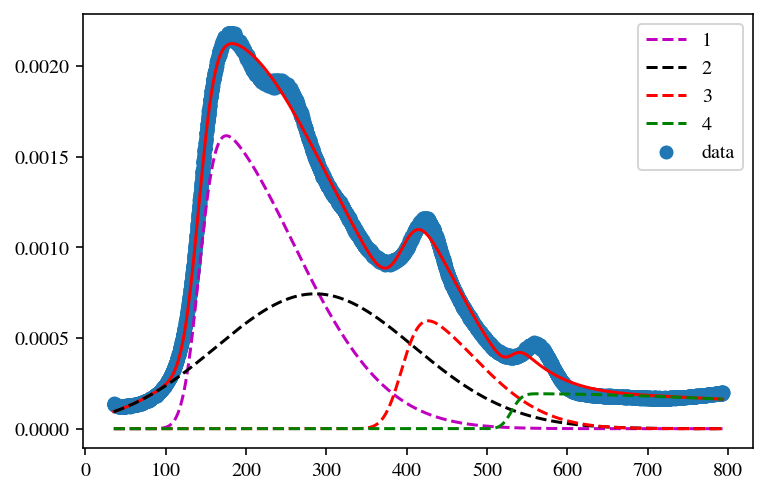

In [49]:
import numpy as np
from lmfit.models import GaussianModel, ExponentialModel,SkewedGaussianModel
import sys
import matplotlib.pyplot as plt

#dat_10 = np.loadtxt('/u/tehra/TDS/Yuri_Ni_SC_data/Ni_SCGH_4H_D10r.txt')
#dat_0 = np.loadtxt('/u/tehra/TDS/Yuri_Ni_SC_data/Ni_SCGH_5H_D0r.txt')

dat_10 = np.loadtxt('/u/tehra/TDS/Haroon_data/30K',skiprows=2, usecols=(2,4),delimiter=',')
dat_0 = np.loadtxt('/u/tehra/TDS/Haroon_data/16K',skiprows=2, usecols=(2,4),delimiter=',')


x = dat_10[:,0]#[530:7100,0]
y = dat_10[:,1]#[530:7100,1]


sgauss1  = SkewedGaussianModel(prefix='sg1_')
pars = sgauss1.guess(y, x=x)
pars.update( sgauss1.make_params())

pars['sg1_center'].set(200, min=0, max=1100)
pars['sg1_sigma'].set(10, min=0)
pars['sg1_amplitude'].set(0.001, min=0)
pars['sg1_gamma'].set(-1)
sgauss2  = SkewedGaussianModel(prefix='sg2_')
pars.update(sgauss2.make_params())

pars['sg2_center'].set(250, min=0, max=1100)
pars['sg2_sigma'].set(10, min=0)
pars['sg2_amplitude'].set(0.001, min=0)
pars['sg2_gamma'].set(-1)

sgauss3  = SkewedGaussianModel(prefix='sg3_')
pars.update( sgauss3.make_params())

pars['sg3_center'].set(400, min=300, max=1100)
pars['sg3_sigma'].set(10, min=0)
pars['sg3_amplitude'].set(0.001, min=0)
pars['sg3_gamma'].set(-1)

sgauss4  = SkewedGaussianModel(prefix='sg4_')

pars.update(sgauss4.make_params())

pars['sg4_center'].set(500, min=300, max=1100)
pars['sg4_sigma'].set(15, min=0)
pars['sg4_amplitude'].set(0.001, min=0)
pars['sg4_gamma'].set(-10)



smod = sgauss1 + sgauss2 + sgauss3 + sgauss4

init = smod.eval(pars, x=x)
plt.scatter(x, y,label='data' )
#plt.plot(x, init, 'k--')

sout = smod.fit(y, pars, x=x)
scomps = sout.eval_components(x=x)
print(sout.fit_report(min_correl=0.5))

plt.plot(x, sout.best_fit, 'r')

plt.plot(x, scomps['sg1_'], 'm--', label='1')
plt.plot(x, scomps['sg2_'], 'k--', label='2')
plt.plot(x, scomps['sg3_'], 'r--', label='3')
plt.plot(x, scomps['sg4_'], 'g--', label='4')
#plt.plot(Trange,0.8*dCrange, label='c1')
#plt.plot(Trange,0.2*dCrange2, label='c2') 
plt.legend()
plt.show()

[[Model]]
    (((Model(skewed_gaussian, prefix='sg1_') + Model(skewed_gaussian, prefix='sg2_')) + Model(skewed_gaussian, prefix='sg3_')) + Model(skewed_gaussian, prefix='sg4_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 730
    # data points      = 11948
    # variables        = 16
    chi-square         = 2.4134e+13
    reduced chi-square = 2.0227e+09
    Akaike info crit   = 256033.852
    Bayesian info crit = 256152.065
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sg1_amplitude:  16263283.6 (init = 2000)
    sg1_center:     301.574702 (init = 600)
    sg1_sigma:      1434738.78 (init = 300)
    sg1_gamma:      5042.84124 (init = -10)
    sg2_amplitude:  15397019.2 (init = 2000)
    sg2_center:     1065.33052 (init = 600)
    sg2_sigma:      1111416.85 (init = 300)
    sg2_gamma:     -46151.2618 (init = -10)
    sg3_amplitude:  1.4687e+08 (init = 2000)
    sg3_center:     305.903256 (init = 600)
    sg3_sigma:      322.877996

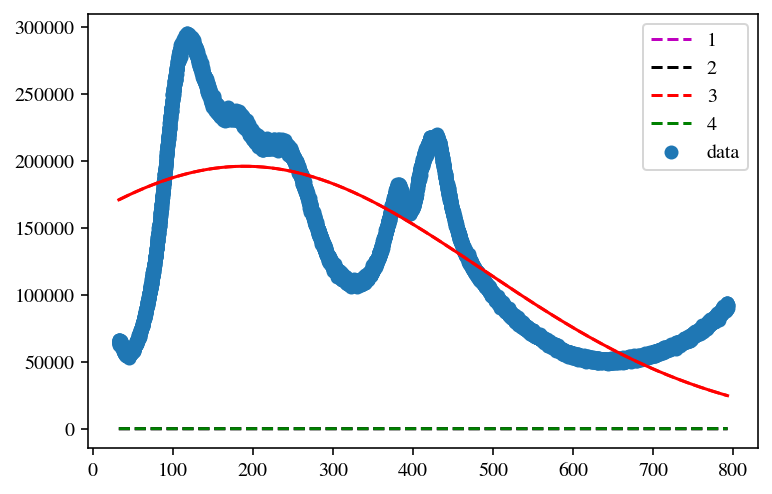

In [34]:
import numpy as np
from lmfit.models import GaussianModel, ExponentialModel,SkewedGaussianModel
import sys
import matplotlib.pyplot as plt

#dat_10 = np.loadtxt('/u/tehra/TDS/Yuri_Ni_SC_data/Ni_SCGH_4H_D10r.txt')
#dat_0 = np.loadtxt('/u/tehra/TDS/Yuri_Ni_SC_data/Ni_SCGH_5H_D0r.txt')

dat_10 = np.loadtxt('/u/tehra/TDS/Haroon_data/30K',skiprows=2, usecols=(2,3),delimiter=',')
dat_0 = np.loadtxt('/u/tehra/TDS/Haroon_data/16K',skiprows=2, usecols=(2,3),delimiter=',')

x = dat_0[:,0]#[680:7100,0]
y = dat_0[:,1]#[680:7100,1]


sgauss1  = SkewedGaussianModel(prefix='sg1_')
pars = sgauss1.guess(y, x=x)
pars.update( sgauss1.make_params())

pars['sg1_center'].set(600, min=300, max=1100)
pars['sg1_sigma'].set(300, min=10)
pars['sg1_amplitude'].set(2000, min=10)
pars['sg1_gamma'].set(-10)
sgauss2  = SkewedGaussianModel(prefix='sg2_')
pars.update(sgauss2.make_params())

pars['sg2_center'].set(600, min=300, max=1100)
pars['sg2_sigma'].set(300, min=10)
pars['sg2_amplitude'].set(2000, min=10)
pars['sg2_gamma'].set(-10)

sgauss3  = SkewedGaussianModel(prefix='sg3_')
pars.update( sgauss3.make_params())

pars['sg3_center'].set(600, min=300, max=1100)
pars['sg3_sigma'].set(300, min=10)
pars['sg3_amplitude'].set(2000, min=10)
pars['sg3_gamma'].set(-1)

sgauss4  = SkewedGaussianModel(prefix='sg4_')

pars.update(sgauss4.make_params())

pars['sg4_center'].set(950, min=300, max=1100)
pars['sg4_sigma'].set(300, min=10)
pars['sg4_amplitude'].set(2000, min=10)
pars['sg4_gamma'].set(-1)



smod = sgauss1 + sgauss2 + sgauss3 + sgauss4

init = smod.eval(pars, x=x)
plt.scatter(x, y,label='data' )
#plt.plot(x, init, 'k--')

sout = smod.fit(y, pars, x=x)
scomps = sout.eval_components(x=x)
print(sout.fit_report(min_correl=0.5))

plt.plot(x, sout.best_fit, 'r')

plt.plot(x, scomps['sg1_'], 'm--', label='1')
plt.plot(x, scomps['sg2_'], 'k--', label='2')
plt.plot(x, scomps['sg3_'], 'r--', label='3')
plt.plot(x, scomps['sg4_'], 'g--', label='4')
#plt.plot(Trange,0.8*dCrange, label='c1')
#plt.plot(Trange,0.2*dCrange2, label='c2') 
plt.legend()
plt.show()

[[Model]]
    (((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_')) + Model(gaussian, prefix='g4_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 347
    # data points      = 6369
    # variables        = 12
    chi-square         = 1.7399e-05
    reduced chi-square = 2.7370e-09
    Akaike info crit   = -125561.861
    Bayesian info crit = -125480.751
[[Variables]]
    g1_amplitude:  0.07148701 +/- 0.00144797 (2.03%) (init = 0.001)
    g1_center:     169.865300 +/- 0.10640362 (0.06%) (init = 200)
    g1_sigma:      25.1717733 +/- 0.21787011 (0.87%) (init = 10)
    g1_fwhm:       59.2749953 +/- 0.51304489 (0.87%) == '2.3548200*g1_sigma'
    g1_height:     0.00113298 +/- 1.4221e-05 (1.26%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:  0.25078173 +/- 0.00324932 (1.30%) (init = 0.001)
    g2_center:     242.671306 +/- 0.50505586 (0.21%) (init = 250)
    g2_sigma:      62.9877091 +/- 0.5253235

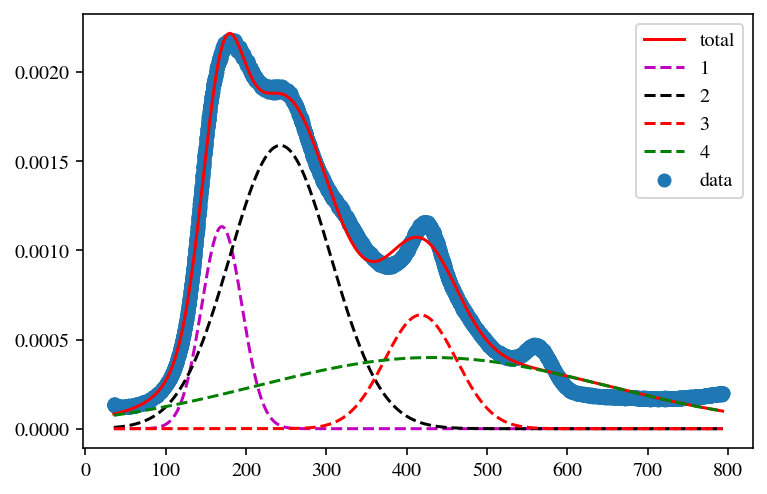

In [53]:
import numpy as np
from lmfit.models import GaussianModel, ExponentialModel
import sys
import matplotlib.pyplot as plt

#dat = np.loadtxt('NIST_Gauss2.dat')

dat_10 = np.loadtxt('/u/tehra/TDS/Haroon_data/30K',skiprows=2, usecols=(2,4),delimiter=',')
dat_0 = np.loadtxt('/u/tehra/TDS/Haroon_data/16K',skiprows=2, usecols=(2,4),delimiter=',')


x = dat_10[:,0]#[530:7100,0]
y = dat_10[:,1]#[530:7100,1]


gauss1  = GaussianModel(prefix='g1_')
pars = gauss1.guess(y, x=x)
pars.update( gauss1.make_params())

pars['g1_center'].set(200, min=0, max=1100)
pars['g1_sigma'].set(10, min=0)
pars['g1_amplitude'].set(0.001, min=0)
#pars['g1_gamma'].set(1)

gauss2  = GaussianModel(prefix='g2_')

pars.update(gauss2.make_params())

pars['g2_center'].set(250, min=0, max=1100)
pars['g2_sigma'].set(10, min=0)
pars['g2_amplitude'].set(0.001, min=0)
#pars['g2_gamma'].set(1)

gauss3  = GaussianModel(prefix='g3_')

pars.update(gauss3.make_params())

pars['g3_center'].set(450, min=300, max=1100)
pars['g3_sigma'].set(10, min=0)
pars['g3_amplitude'].set(0.001, min=0)

gauss4  = GaussianModel(prefix='g4_')

pars.update(gauss4.make_params())

pars['g4_center'].set(500, min=300, max=1100)
pars['g4_sigma'].set(10, min=0)
pars['g4_amplitude'].set(0.001, min=0)



mod = gauss1 + gauss2 + gauss3 + gauss4

init = mod.eval(pars, x=x)
plt.scatter(x, y,label='data')
#plt.plot(x, init, 'k--')

out = mod.fit(y, pars, x=x)
comps = out.eval_components(x=x)
print(out.fit_report(min_correl=0.5))
plt.plot(x, out.best_fit, 'r-',label='total')
plt.plot(x, comps['g1_'], 'm--', label='1')
plt.plot(x, comps['g2_'], 'k--', label='2')
plt.plot(x, comps['g3_'], 'r--', label='3')
plt.plot(x, comps['g4_'], 'g--', label='4')
#plt.plot(Trange,0.8*dCrange, label='c1')
#plt.plot(Trange,0.2*dCrange2, label='c2') 
plt.legend()
plt.show()

[[Model]]
    (((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_')) + Model(gaussian, prefix='g4_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26000
    # data points      = 6420
    # variables        = 12
    chi-square         = 15.4865892
    reduced chi-square = 0.00241676
    Akaike info crit   = -38670.6173
    Bayesian info crit = -38589.4112
##  Warning: uncertainties could not be estimated:
    g4_amplitude:  at boundary
[[Variables]]
    g1_amplitude:  36.5271649 (init = 2000)
    g1_center:     306.928456 (init = 600)
    g1_sigma:      588.383225 (init = 300)
    g1_fwhm:       1385.53659 == '2.3548200*g1_sigma'
    g1_height:     0.02476656 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:  202.428533 (init = 2000)
    g2_center:     558.949292 (init = 600)
    g2_sigma:      60.5105699 (init = 300)
    g2_fwhm:       142.491500 == '2.3548200*g2_sigma'
    g2_height:     1.334

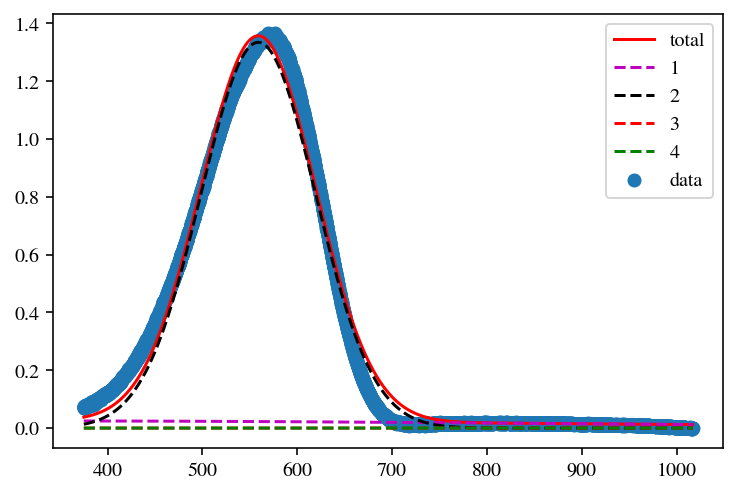

In [23]:
import numpy as np
from lmfit.models import GaussianModel, ExponentialModel
import sys
import matplotlib.pyplot as plt

#dat = np.loadtxt('NIST_Gauss2.dat')
dat_10 = np.loadtxt('/u/tehra/TDS/Yuri_Ni_SC_data/Ni_SCGH_4H_D10r.txt')
dat_0 = np.loadtxt('/u/tehra/TDS/Yuri_Ni_SC_data/Ni_SCGH_5H_D0r.txt')
x = dat_0[680:7100,0]
y = dat_0[680:7100,1]


gauss1  = GaussianModel(prefix='g1_')
pars = gauss1.guess(y, x=x)
pars.update( gauss1.make_params())

pars['g1_center'].set(600, min=300, max=1100)
pars['g1_sigma'].set(300, min=10)
pars['g1_amplitude'].set(2000, min=0)
#pars['g1_gamma'].set(1)

gauss2  = GaussianModel(prefix='g2_')

pars.update(gauss2.make_params())

pars['g2_center'].set(600, min=300, max=1100)
pars['g2_sigma'].set(300, min=10)
pars['g2_amplitude'].set(2000, min=0)
#pars['g2_gamma'].set(1)

gauss3  = GaussianModel(prefix='g3_')

pars.update(gauss3.make_params())

pars['g3_center'].set(600, min=300, max=1100)
pars['g3_sigma'].set(300, min=10)
pars['g3_amplitude'].set(2000, min=0)

gauss4  = GaussianModel(prefix='g4_')

pars.update(gauss4.make_params())

pars['g4_center'].set(950, min=300, max=1100)
pars['g4_sigma'].set(300, min=10)
pars['g4_amplitude'].set(2000, min=0)



mod = gauss1 + gauss2 + gauss3 + gauss4

init = mod.eval(pars, x=x)
plt.scatter(x, y,label='data')
#plt.plot(x, init, 'k--')

out = mod.fit(y, pars, x=x)
comps = out.eval_components(x=x)
print(out.fit_report(min_correl=0.5))
plt.plot(x, out.best_fit, 'r-',label='total')
plt.plot(x, comps['g1_'], 'm--', label='1')
plt.plot(x, comps['g2_'], 'k--', label='2')
plt.plot(x, comps['g3_'], 'r--', label='3')
plt.plot(x, comps['g4_'], 'g--', label='4')
#plt.plot(Trange,0.8*dCrange, label='c1')
#plt.plot(Trange,0.2*dCrange2, label='c2') 
plt.legend()
plt.show()

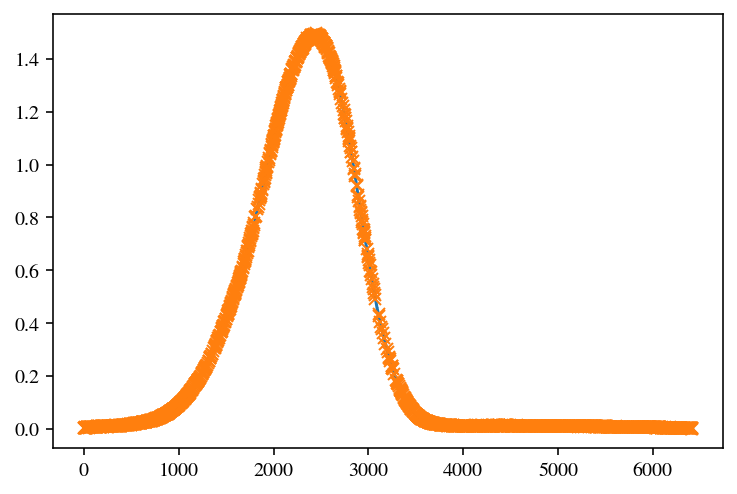

In [24]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
#x = electrocardiogram()[2000:4000]
dat_10 = np.loadtxt('/u/tehra/TDS/Yuri_Ni_SC_data/Ni_SCGH_4H_D10r.txt')
dat_0 = np.loadtxt('/u/tehra/TDS/Yuri_Ni_SC_data/Ni_SCGH_5H_D0r.txt')
#x = dat_0[680:7100,0]
x = dat_10[680:7100,1]
#x=myDistrib


peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

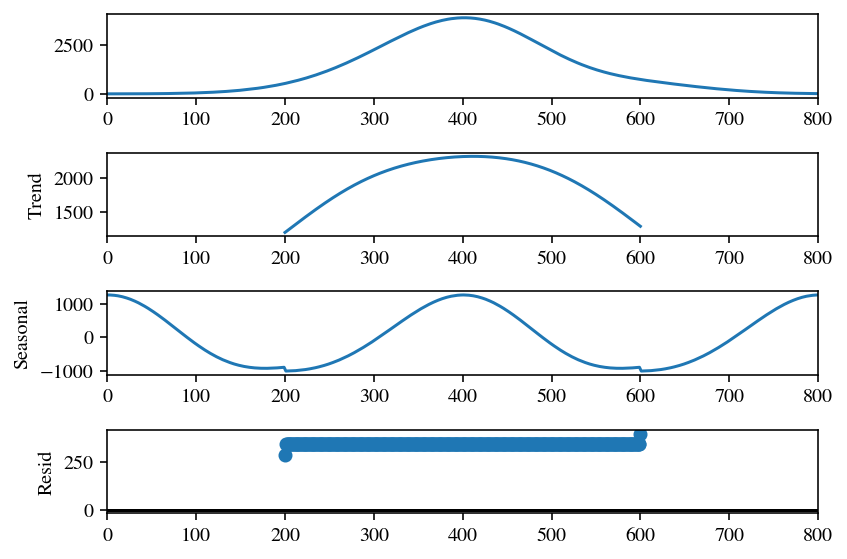

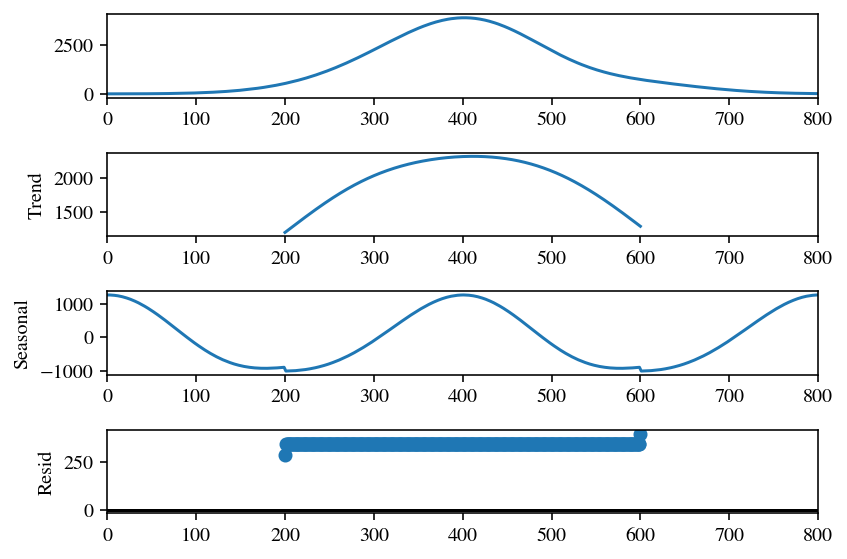

In [159]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Generate some data
np.random.seed(0)
data = myDistrib #dat_10[680:7100,1]
df = pd.DataFrame({'data': data})
seasonal_decompose(df, model='additive',period=400).plot()
